# Notebook for creating train field

## Imports and constants

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [84]:
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SPREAD_ID = 6
FUNDING_RATE_ID = 1
COMMISION_VALUE = 0.08
POSITION_TYPE = 1
SMOOTH_TIME_RADIUS = 500
DY = COMMISION_VALUE + 0.005
SHIFT = 64

## Train modifications

In [4]:
train = pd.read_csv(TRAIN_FILENAME, dtype={'timestamp': np.int64}, index_col='timestamp')
train.head()

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min,target
timestamp,,,,,,,,,,
1617482880,4473.0,0.000521,400.630,4.0,0.059,7125120.0,7.852325,-0.422779,-3.39489,9.51559
1617482940,2854.0,0.000521,249.644,2.0,0.066,7125060.0,7.880229,-0.422779,-3.39489,9.51559
1617483000,2555.0,0.000521,214.457,6.0,0.353,7125000.0,7.892018,-0.422779,-3.39489,9.51559
1617483060,1768.0,0.000521,148.087,12.0,0.330,7124940.0,7.902424,-0.422779,-3.39489,9.51559
1617483120,2280.0,0.000521,172.108,2.0,0.017,7124880.0,7.962683,-0.422779,-3.39489,9.51559


In [6]:
spreads = train.iloc[:, SPREAD_ID].to_numpy()
spread_0 = train.iloc[0, SPREAD_ID]
rewards = POSITION_TYPE * (spread_0 - spreads) - COMMISION_VALUE \
                    - POSITION_TYPE * train.iloc[:, FUNDING_RATE_ID].cumsum()

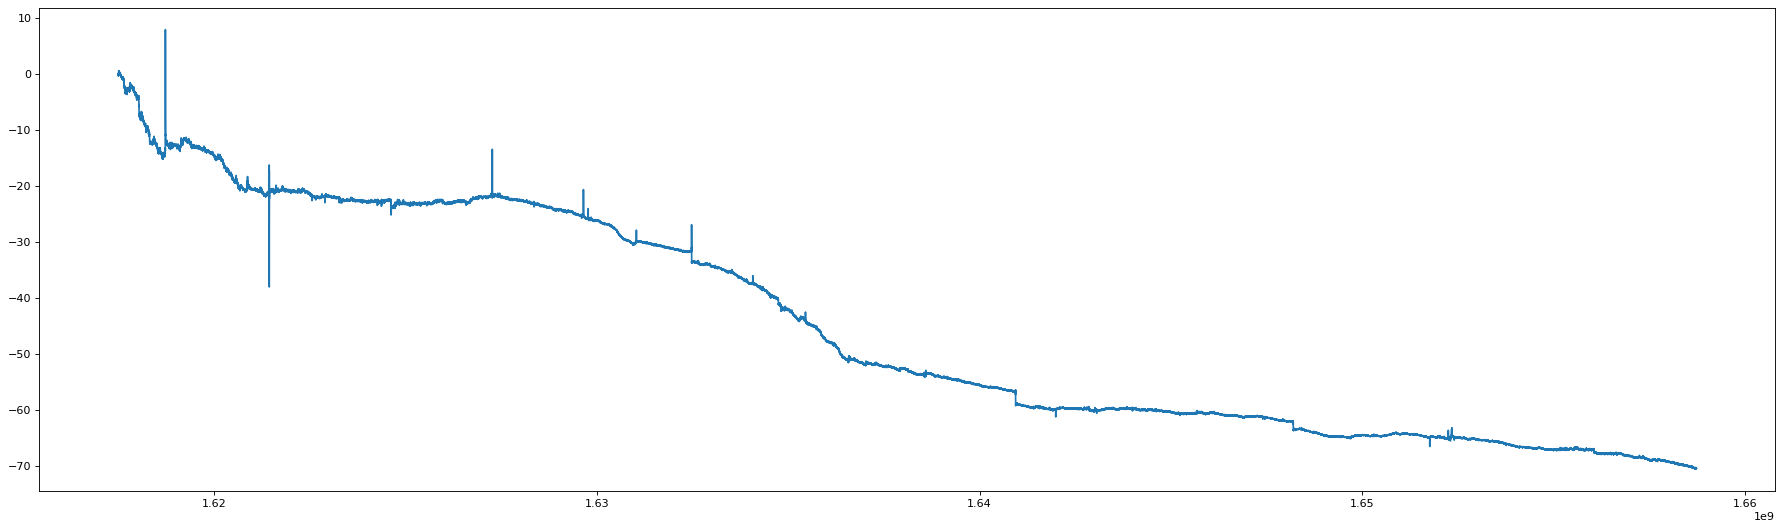

In [8]:
plt.figure(figsize=(28, 8), dpi=80)
plt.plot(train.index, rewards)
plt.show()

### Smoothing (averaging)

In [9]:
def smooth_avg(time_ax, value_ax, time_radius: float) -> np.ndarray:
    arr = np.column_stack((np.array(time_ax), np.array(value_ax)))
    length = np.size(value_ax, axis=0)
    if length == 1:
        return value_ax
    ret = np.array(value_ax)
    for i in np.arange(length):
        t = arr[i, 0]
        nearby_values = np.array([arr[i, 1]])
        j = i - 1
        while j >= 0 and t - arr[j, 0] <= time_radius:
            nearby_values = np.append(nearby_values, [arr[j, 1]])
            j -= 1
        j = i + 1
        while j < length and arr[j, 0] - t <= time_radius:
            nearby_values = np.append(nearby_values, [arr[j, 1]])
            j += 1
        ret[i] = np.average(nearby_values)
    return ret

In [12]:
smooth_rewards1 = smooth_avg(train.index, rewards, SMOOTH_TIME_RADIUS)

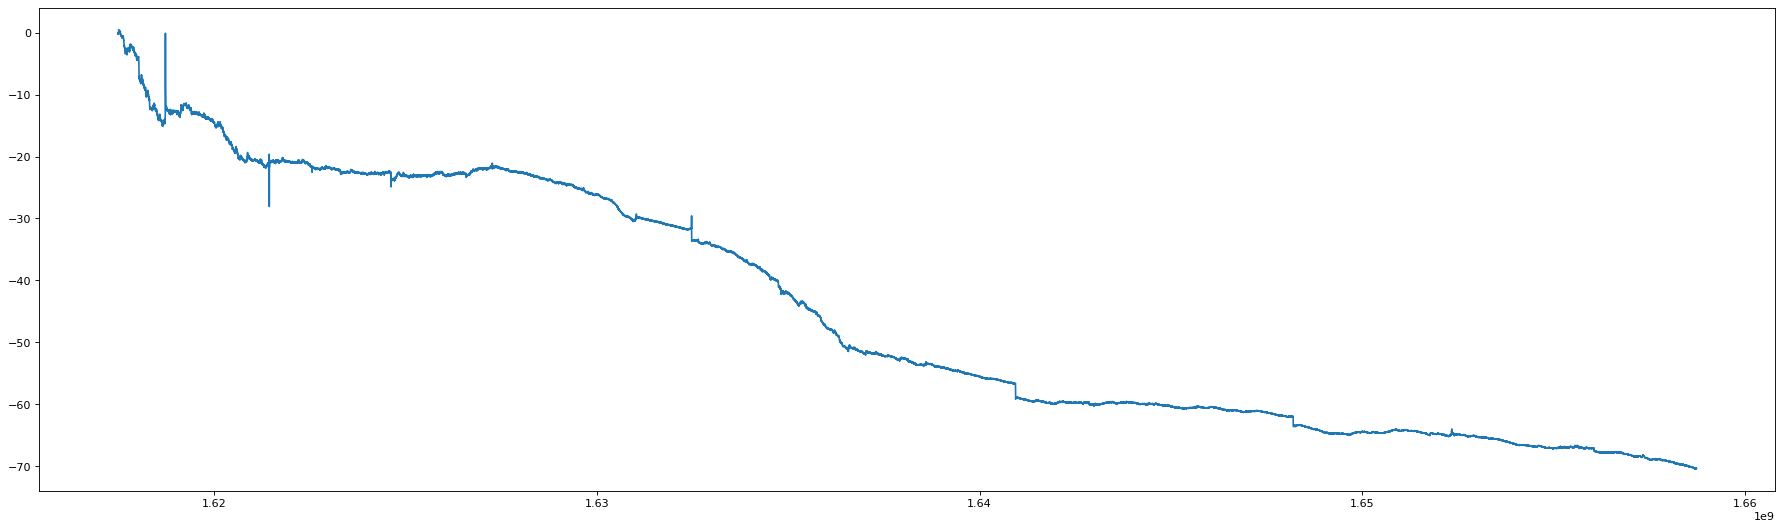

In [13]:
plt.figure(figsize=(28, 8), dpi=80)
plt.plot(train.index, smooth_rewards1)
plt.show()

Difference between smoothed and unsmoothed:

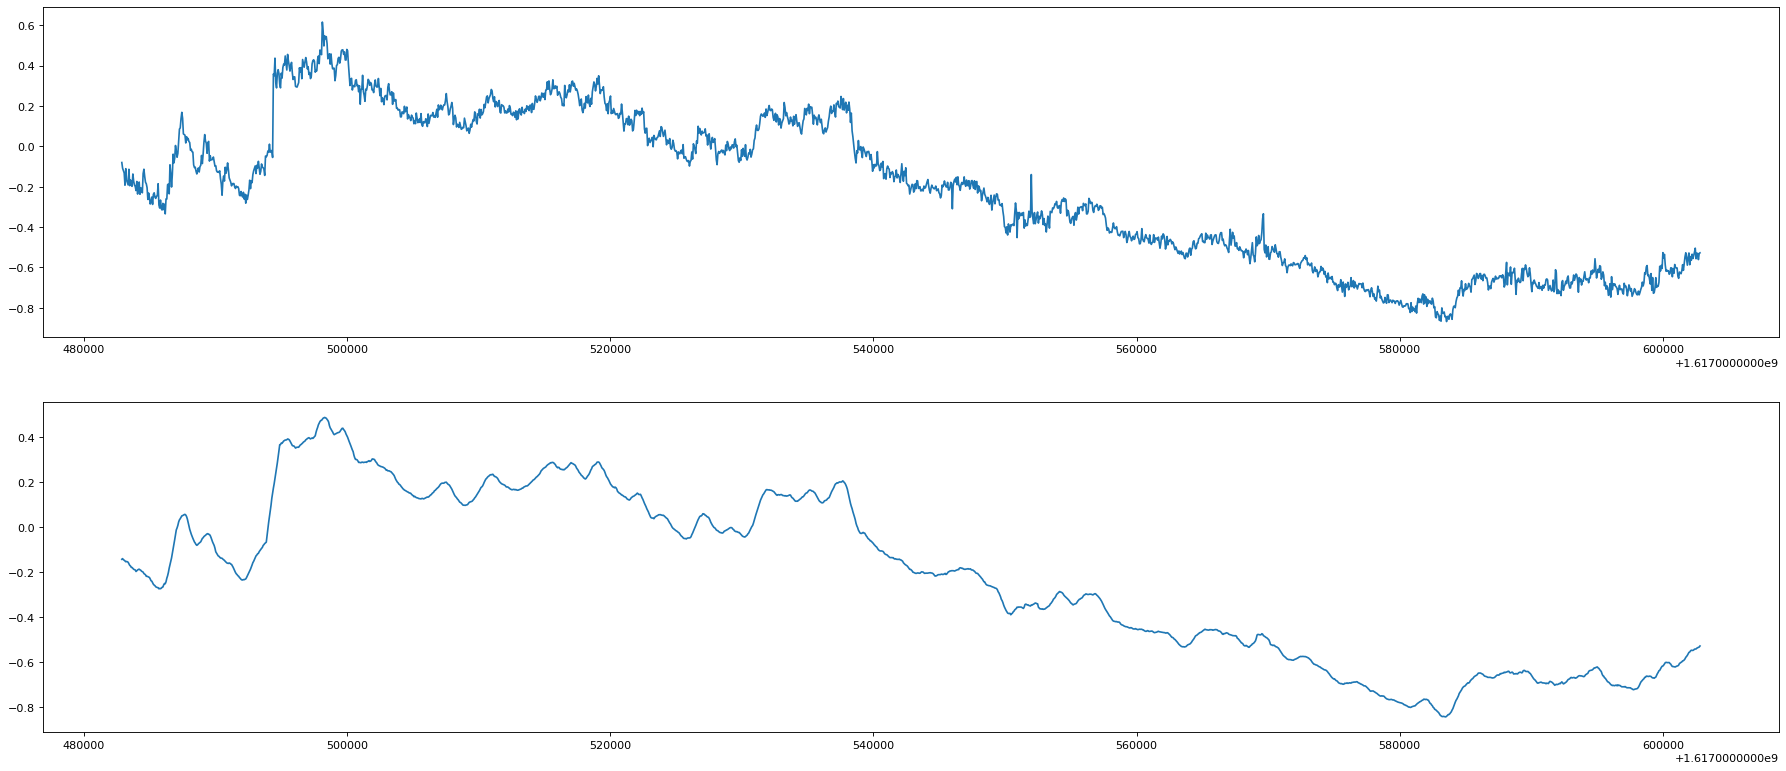

In [18]:
plot_start = 0
plot_end = 2000

plt.figure(figsize=(28, 12), dpi=80)
ax1 = plt.subplot(2, 1, 1)
ax1.plot(train.index[plot_start:plot_end], rewards.iloc[plot_start:plot_end])

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(train.index[plot_start:plot_end], smooth_rewards1[plot_start:plot_end])

plt.show()

### Search for local extremas

In [14]:
def find_local_extrema(data: np.ndarray) -> np.ndarray:
    return np.array(
        [0] + list([el + 1 for el in np.where(np.abs(np.diff(np.sign(np.diff(data))))
                   == 2)][0]) + [len(data) - 1]
    )

In [19]:
extrema_indices: np.ndarray = find_local_extrema(smooth_rewards1)

In [28]:
def print_extremas_stats(extremas):
    print(f"There are {len(extremas)} extrema candidates now ({100*(len(extremas)/len(train)):.2f}% of train points)")
print_extremas_stats(extrema_indices)

There are 176357 extrema candidates now (25.65% of train points)


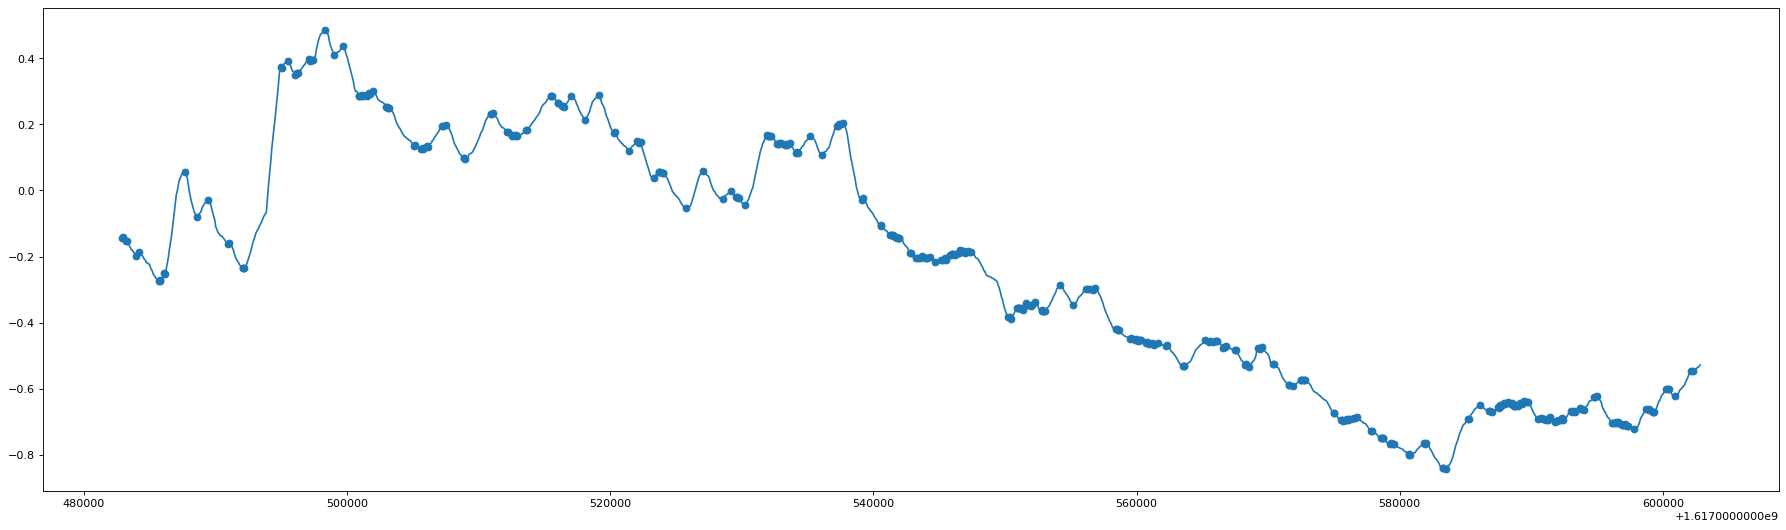

In [33]:
plot_start = 0
plot_end = 2000

plt.figure(figsize=(28, 8), dpi=80)

plt.plot(train.index[plot_start:plot_end], smooth_rewards1[plot_start:plot_end])
extrema_indices_filtered_plot = extrema_indices[(extrema_indices >= plot_start) & (extrema_indices <= plot_end)]
plt.scatter(np.array(train.index[plot_start:plot_end])
            [extrema_indices_filtered_plot], smooth_rewards1[extrema_indices_filtered_plot])
plt.show()

### Filtering local extremas

In [29]:
def filter_extrema(indices: np.ndarray, data: np.ndarray) -> np.ndarray:
    def filter_impl(el: tuple[int, tuple[np.int64, np.float64]]):
        (i, (ex, x)) = el
        return i > 0 and np.abs(data[indices[i - 1]] - x) >= DY or i < len(indices) - 1 and np.abs(data[indices[i + 1]] - x) >= DY

    return np.fromiter(map(lambda idx_x: idx_x[1][0],
                           filter(filter_impl, enumerate(zip(indices, data[indices])))),
                       dtype=np.int64)

In [30]:
filtered_extrema_indices: np.ndarray = filter_extrema(extrema_indices, smooth_rewards1)

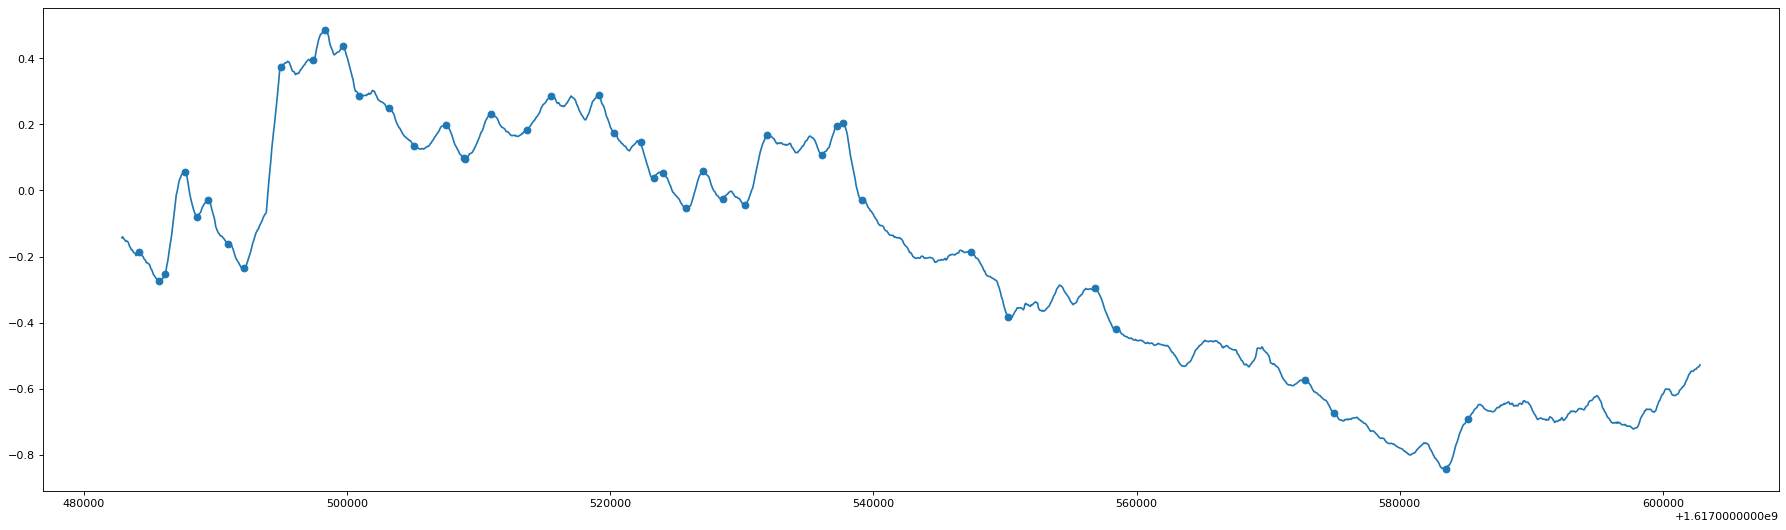

In [32]:
plot_start = 0
plot_end = 2000

plt.figure(figsize=(28, 8), dpi=80)

plt.plot(train.index[plot_start:plot_end], smooth_rewards1[plot_start:plot_end])
filtered_extrema_indices_filtered_plot = filtered_extrema_indices[(filtered_extrema_indices >= plot_start) & (filtered_extrema_indices <= plot_end)]
plt.scatter(np.array(train.index[plot_start:plot_end])
            [filtered_extrema_indices_filtered_plot], smooth_rewards1[filtered_extrema_indices_filtered_plot])
plt.show()

In [34]:
print_extremas_stats(filtered_extrema_indices)

There are 4415 extrema candidates now (0.64% of train points)


In [35]:
def filter_extrema_grouped(indices: np.ndarray, data: np.ndarray) -> np.ndarray:
    def filter_impl_grouped(el: tuple[int, np.float64]):
        (i, (x, y)) = el

        dy = 0.085
        dx = 5
        return i == 0 or not (np.abs(data[indices[i - 1]] - y) <= dy and np.abs(x - indices[i - 1]) <= dx) or i == len(indices) - 1

    return np.fromiter(map(lambda idx_x: idx_x[1][0],
                           filter(filter_impl_grouped, enumerate(zip(indices, data[indices])))),
                       dtype=np.int64)

In [46]:
filtered_extrema_indices_2: np.ndarray = filter_extrema_grouped(
    filtered_extrema_indices, smooth_rewards1)

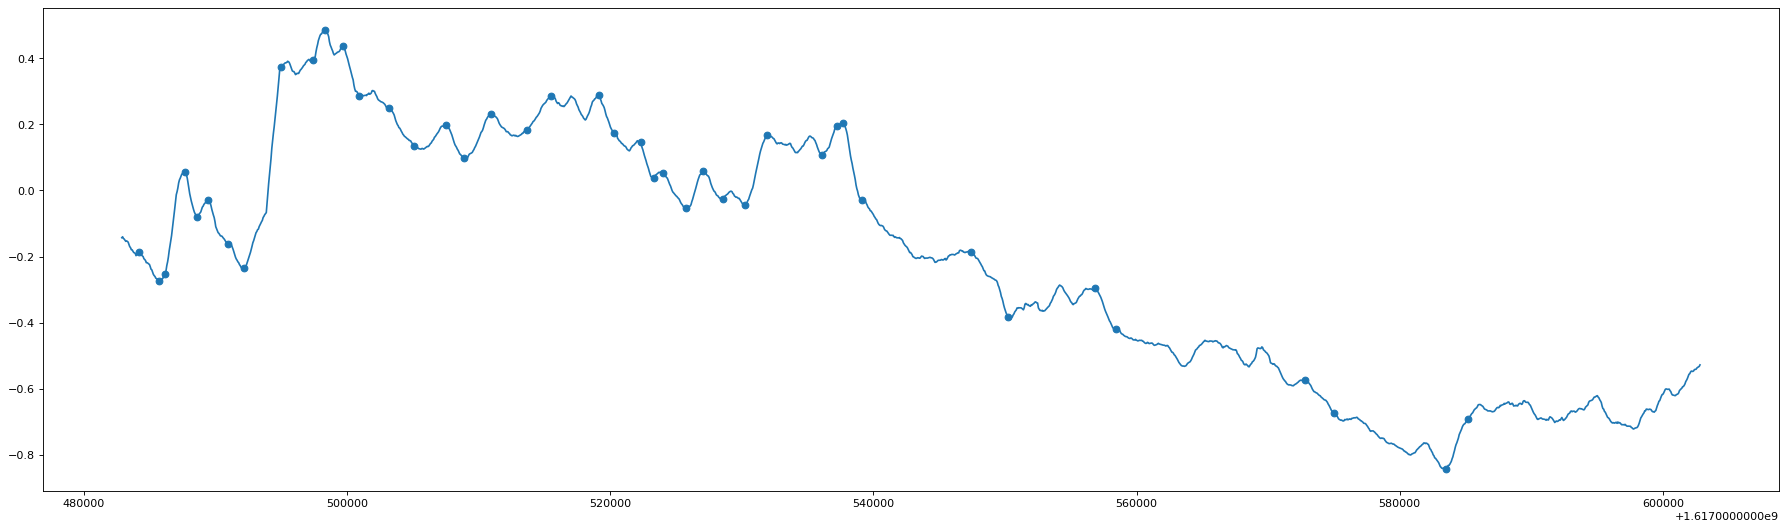

In [47]:
plot_start = 0
plot_end = 2000

plt.figure(figsize=(28, 8), dpi=80)

plt.plot(train.index[plot_start:plot_end], smooth_rewards1[plot_start:plot_end])
filtered_extrema_indices_2_filtered_plot = filtered_extrema_indices_2[(filtered_extrema_indices_2 >= plot_start) & (filtered_extrema_indices_2 <= plot_end)]
plt.scatter(np.array(train.index[plot_start:plot_end])
            [filtered_extrema_indices_2_filtered_plot], smooth_rewards1[filtered_extrema_indices_2_filtered_plot])
plt.show()

In [48]:
print_extremas_stats(filtered_extrema_indices_2)

There are 4225 extrema candidates now (0.61% of train points)


In [49]:
def filter_extrema_hill_points(indices: np.ndarray, data: np.ndarray) -> np.ndarray:
    def filter_impl_hill_points(el: tuple[int, np.float64]):
        (i, (x, y)) = el

        dy = 0.085
        dx = 5
        return i == 0 or i == len(indices) - 1 or y <= data[indices[i-1]] and y <= data[indices[i+1]] or y >= data[indices[i-1]] and y >= data[indices[i+1]]

    return np.fromiter(map(lambda idx_x: idx_x[1][0],
                           filter(filter_impl_hill_points, enumerate(zip(indices, data[indices])))),
                       dtype=np.int64)

In [50]:
filtered_extrema_indices_3: np.ndarray = filter_extrema_hill_points(
    filtered_extrema_indices_2, smooth_rewards1)

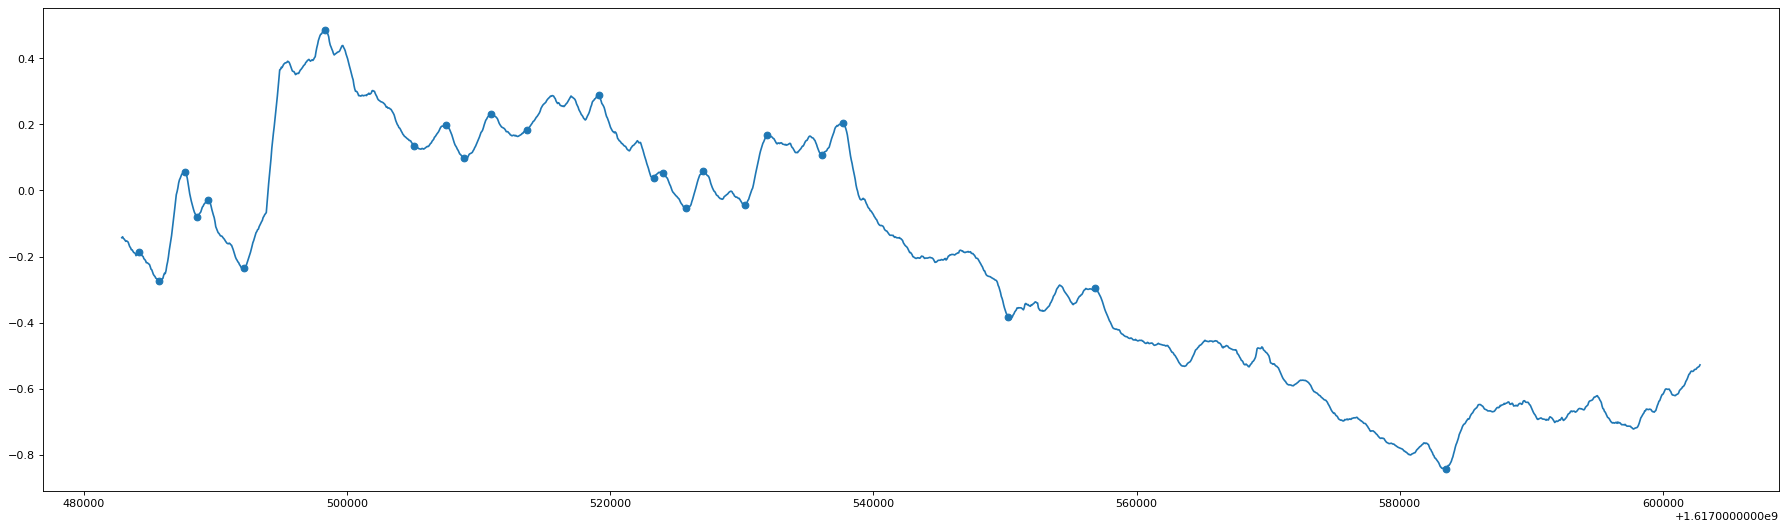

In [51]:
plot_start = 0
plot_end = 2000

plt.figure(figsize=(28, 8), dpi=80)

plt.plot(train.index[plot_start:plot_end], smooth_rewards1[plot_start:plot_end])
filtered_extrema_indices_3_filtered_plot = filtered_extrema_indices_3[(filtered_extrema_indices_3 >= plot_start) & (filtered_extrema_indices_3 <= plot_end)]
plt.scatter(np.array(train.index[plot_start:plot_end])
            [filtered_extrema_indices_3_filtered_plot], smooth_rewards1[filtered_extrema_indices_3_filtered_plot])
plt.show()

In [52]:
print_extremas_stats(filtered_extrema_indices_3)

There are 2655 extrema candidates now (0.39% of train points)


In [61]:
def calc_reward(extremas):
    sum_points = 0
    for i, extrema_idx in enumerate(extremas[:-1]):
        # first position is on decrease, and then alternates
        position_type = int(i % 2 == 1) * 2 - 1
        spread_start = train.iloc[extrema_idx, SPREAD_ID]
        spread_end = train.iloc[extremas[i+1] - 1, SPREAD_ID]
        reward = position_type * (spread_start - spread_end) - COMMISION_VALUE
        reward -= position_type * train.iloc[extrema_idx:extremas[i+1] - 1, FUNDING_RATE_ID].sum()
        sum_points += reward
    return sum_points

In [62]:
calc_reward(filtered_extrema_indices_3)

351.6960103329317

## Creating new train using extremas

In [63]:
new_train_2sided = train.copy()
new_train_2sided['target'] = 0
new_train_2sided.head(4)

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min,target
timestamp,,,,,,,,,,
1617482880,4473.0,0.000521,400.630,4.0,0.059,7125120.0,7.852325,-0.422779,-3.39489,0
1617482940,2854.0,0.000521,249.644,2.0,0.066,7125060.0,7.880229,-0.422779,-3.39489,0
1617483000,2555.0,0.000521,214.457,6.0,0.353,7125000.0,7.892018,-0.422779,-3.39489,0
1617483060,1768.0,0.000521,148.087,12.0,0.330,7124940.0,7.902424,-0.422779,-3.39489,0


1 якщо зростає, 0 якщо спадає

In [72]:
filtered_extrema_indices_3

array([    22,     47,     80, ..., 681761, 686647, 687266], dtype=int64)

In [74]:
for i, extrema in enumerate(filtered_extrema_indices_3[:-1]):
    if rewards.iloc[extrema] < rewards.iloc[filtered_extrema_indices_3[i + 1]]:
        new_train_2sided.iloc[extrema:filtered_extrema_indices_3[i + 1], -1] = 1

In [75]:
new_train_2sided

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min,target
timestamp,,,,,,,,,,
1617482880,4473.0,0.000521,400.630,4.0,0.059,7125120.0,7.852325,-0.422779,-3.394890,0
1617482940,2854.0,0.000521,249.644,2.0,0.066,7125060.0,7.880229,-0.422779,-3.394890,0
1617483000,2555.0,0.000521,214.457,6.0,0.353,7125000.0,7.892018,-0.422779,-3.394890,0
1617483060,1768.0,0.000521,148.087,12.0,0.330,7124940.0,7.902424,-0.422779,-3.394890,0
1617483120,2280.0,0.000521,172.108,2.0,0.017,7124880.0,7.962683,-0.422779,-3.394890,0
...,...,...,...,...,...,...,...,...,...,...
1658731800,290.0,0.000044,23.098,11.0,0.924,5793000.0,0.586437,0.000000,-3.023083,0
1658731860,209.0,0.000044,15.790,1.0,0.009,5792940.0,0.593701,0.000000,-3.023083,0
1658731920,160.0,0.000044,7.790,1.0,0.068,5792880.0,0.572481,0.000000,-3.023083,0


In [76]:
print(f"1 among all targets: {new_train_2sided['target'].sum()}/{new_train_2sided['target'].count()}\nIt's {new_train_2sided['target'].sum()/new_train_2sided['target'].count()} of all values")

1 among all targets: 183997/687484
It's 0.2676382286715036 of all values


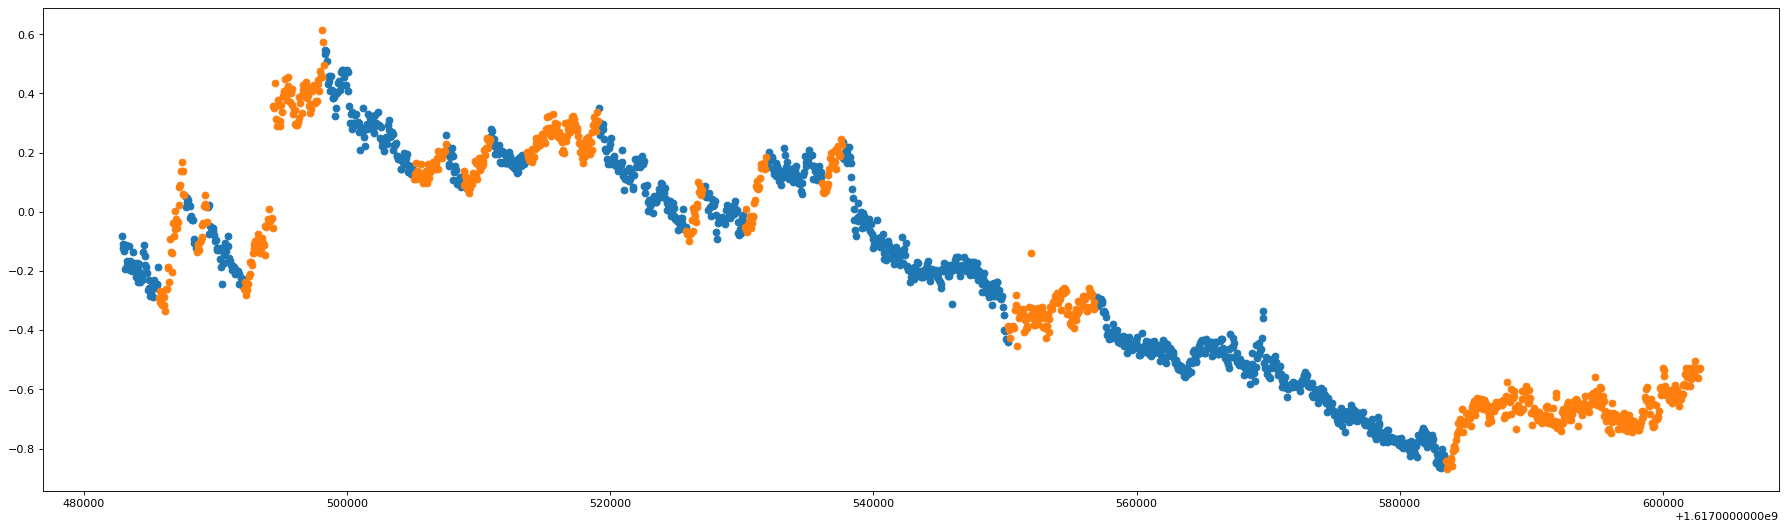

In [81]:
plot_start = 0
plot_end = 2000

plt.figure(figsize=(28, 8), dpi=80)

plt.scatter(train.index[plot_start:plot_end][new_train_2sided.iloc[plot_start:plot_end, -1] == 0], 
    rewards.iloc[plot_start:plot_end][new_train_2sided.iloc[plot_start:plot_end, -1] == 0])
plt.scatter(train.index[plot_start:plot_end][new_train_2sided.iloc[plot_start:plot_end, -1] == 1], 
    rewards.iloc[plot_start:plot_end][new_train_2sided.iloc[plot_start:plot_end, -1] == 1])
plt.show()

In [82]:
new_train_2sided.to_csv('new_train_2sided.csv')

### Extending it (and test) for non-recurrent models usage

In [85]:
test = pd.read_csv(TEST_FILENAME, dtype={'timestamp': np.int64}, index_col='timestamp')
test.head()

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min
timestamp,,,,,,,,,
1658732100,163.0,0.000044,14.162,2.0,0.039,5792700.0,0.600157,0.0,-3.023083
1658732160,133.0,0.000044,13.289,0.0,0.000,5792640.0,0.580793,0.0,-3.023083
1658732220,117.0,0.000045,8.574,0.0,0.000,5792580.0,0.638621,0.0,-3.023083
1658732280,725.0,0.000044,112.460,9.0,0.401,5792520.0,0.611762,0.0,-3.023083
1658732340,258.0,0.000044,25.349,0.0,0.000,5792460.0,0.649675,0.0,-3.023083


In [86]:
new_train_extended = new_train_2sided.iloc[SHIFT - 1:].reset_index().drop('timestamp', axis=1)
new_test_extended = test.iloc[SHIFT - 1:].reset_index().drop('timestamp', axis=1)
for s in range(1, SHIFT):
    new_part = new_train_2sided.iloc[SHIFT - 1 - s:-s, :-1].reset_index().drop('timestamp', axis=1)
    new_train_extended = new_train_extended.merge(new_part, left_index=True, right_index=True, suffixes=('', f'-{s}'))
    new_part_test = test.iloc[SHIFT - 1 - s:-s].reset_index().drop('timestamp', axis=1)
    new_test_extended = new_test_extended.merge(new_part_test, left_index=True, right_index=True, suffixes=('', f'-{s}'))

In [87]:
new_train_extended.head()

,number_of_trades_p,funding_rate,volume_p,number_of_trades_q,volume_q,time_left,spread,price_change_d_max,price_change_d_min,target,...,price_change_d_min-62,number_of_trades_p-63,funding_rate-63,volume_p-63,number_of_trades_q-63,volume_q-63,time_left-63,spread-63,price_change_d_max-63,price_change_d_min-63
0,1424.0,0.000521,182.208,1.0,0.159,7121340.0,7.941044,-0.422779,-3.39489,1,...,-3.39489,4473.0,0.000521,400.630,4.0,0.059,7125120.0,7.852325,-0.422779,-3.39489
1,13102.0,0.000521,1149.350,63.0,1.205,7121280.0,7.878363,-0.422779,-3.39489,1,...,-3.39489,2854.0,0.000521,249.644,2.0,0.066,7125060.0,7.880229,-0.422779,-3.39489
2,14929.0,0.000521,1745.533,103.0,5.282,7121220.0,7.777068,-0.422779,-3.39489,1,...,-3.39489,2555.0,0.000521,214.457,6.0,0.353,7125000.0,7.892018,-0.422779,-3.39489
3,3982.0,0.000521,327.739,18.0,0.393,7121160.0,7.819870,-0.422779,-3.39489,1,...,-3.39489,1768.0,0.000521,148.087,12.0,0.330,7124940.0,7.902424,-0.422779,-3.39489
4,3526.0,0.000521,328.421,31.0,0.718,7121100.0,7.795760,-0.422779,-3.39489,1,...,-3.39489,2280.0,0.000521,172.108,2.0,0.017,7124880.0,7.962683,-0.422779,-3.39489


In [92]:
new_train_extended.shape

(687421, 577)

In [91]:
new_train_extended.to_parquet('new_train_2sided_extended.snappy.parquet', engine='fastparquet', index=False)
new_test_extended.to_parquet('new_test_extended.snappy.parquet', engine='fastparquet', index=False)